In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

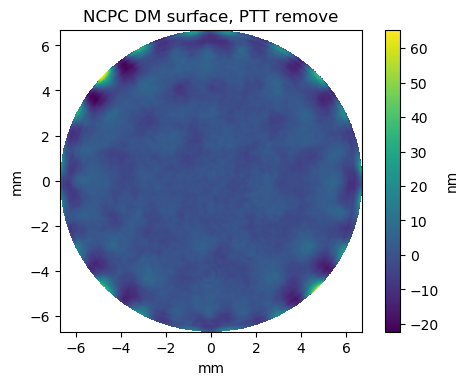

In [2]:
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'label': 'ncpc',
             'surf_units': u.micron,
             'ring_width': 3,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

ncpc_raw = fits.open('zygo_data/DM/ncpc_flat.fits')[0].data * opt_parms['surf_units']
ncpc_pixscl = (0.017219388 * u.mm).to(u.m)/u.pix

# resize the matrix. Zygo does weird things with size of data.
# numbers and sides determined from probing, already deleted.
ncpc_dm = ncpc_raw[:, 3:ncpc_raw.shape[1]-1]

# make a mask
cen = int(ncpc_dm.shape[0]/2)
yy, xx = np.mgrid[-cen:cen, -cen:cen]
mask = (yy**2 + xx**2 <= cen**2)

# aply mask to wfdm
ncpc_dm = ncpc_dm*mask

# show surface
dfx.show_image(data=dfx.sn_map((ncpc_dm.to(u.nm)).value, mask),
               data_unit=u.nm,
               pixscale=(ncpc_pixscl*u.pix).to(u.mm),
               fig_title='NCPC DM surface, PTT remove')

In [3]:
%%time
# now calculate the PSD
ncpc = psd.surfPSD(surf_name='NCPC DM')
ncpc.load_surf(data=ncpc_dm, wavelen=632e-9*u.m, latres=ncpc_pixscl)
ncpc.load_mask(mask=mask)
ncpc.calc_psd(oversamp=opt_parms['ovs'])
ncpc.calc_psd_radial(ring_width=opt_parms['ring_width'], kmin=ncpc.k_min)
ncpc.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'],
                  pwr_opt=ncpc.psd_cal, print_rms=False, print_kloc=False)

CPU times: user 2min 32s, sys: 59.3 s, total: 3min 32s
Wall time: 3min 31s


Text(0, 0.5, 'Power Spectrum [$nm^{2}$$m^{2}$]')

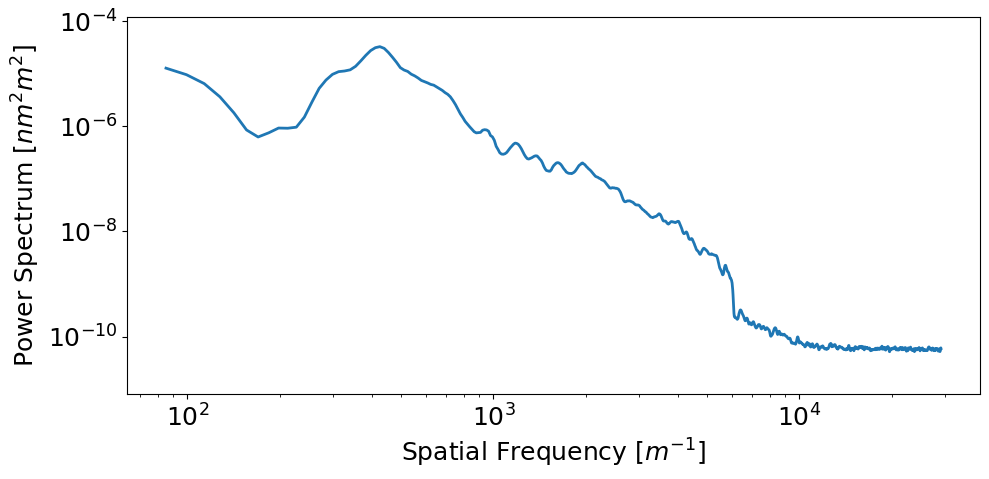

In [4]:
ylim = [1e-4, 1e-11]
xlim = [5, 5e5]

k_radial = ncpc.k_radial.value
psd_radial = ncpc.psd_radial_cal.value

matplotlib.rcParams["font.size"]=18
plt.figure(figsize=[11,5], dpi=100)
plt.loglog(k_radial, psd_radial, linewidth=2)
plt.ylim(top=ylim[0]*1.2, bottom=ylim[1]*0.8)
#plt.xlim(left=xlim[0]*0.8, right=xlim[1]*1.2)
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))

In [5]:
# save the radial data
psd_dict = {'k_radial': ncpc.k_radial,
            'psd_radial': ncpc.psd_radial_cal,
            'rms_tot': ncpc.rms_tot,
            'var': 0*u.nm**2,
            'diam_ca': ncpc.diam_ca,
            'npix_diam': ncpc.npix_diam,
            'oversamp': ncpc.oversamp,
            'delta_k': ncpc.delta_k,
            'k_min': ncpc.k_min,
            'k_max': ncpc.k_max,
            'ring_width': opt_parms['ring_width']}

psd.psd_radial_to_fits(psd_dict=psd_dict, opt_name=opt_parms['label'],
                       fits_filename='radial/psd_{0}.fits'.format(opt_parms['label']))

#### Calculating rms based on beam diameter

In [8]:
opt_parms['rms_tot'] = ncpc.rms_tot
kmax = ncpc.k_max
side = ncpc.psd_cal.shape[0]
dx = 1/(side*ncpc.delta_k)

# make calculations
print('Optic Test: {0}'.format(opt_parms['label']))
print('total paraxial rms: {0:.7f}'.format(opt_parms['rms_tot']))
print('-----')
optic_name = ['ncpc']
beam_diam = [0.0090257*u.m]
angle = [40.5*u.deg]
for j in range(0, len(beam_diam)):
    kmin = 1/beam_diam[j]
    print('optic: {0}, beam_diam = {1:.7f}'.format(optic_name[j], beam_diam[j]))
    rms = psd.do_psd_rms(psd_data=ncpc.psd_cal, delta_k=ncpc.delta_k, k_tgt_lim=[kmin, kmax], 
                         print_rms=False, print_kloc=False)
    angle_rms = rms/np.cos(angle[j]).value
    refl_ang_rms = 2*angle_rms
    print('paraxial rms: {0:.7f}'.format(rms))
    print('angled wfe rms: {0:.7f}'.format(angle_rms))
    print('angled reflected wfe rms (opd): {0:.7f}'.format(refl_ang_rms))
    print('-----')

Optic Test: ncpc
total paraxial rms: 4.8015141 nm
-----
optic: ncpc, beam_diam = 0.0090257 m
paraxial rms: 4.7751787 nm
angled wfe rms: 6.2797754 nm
angled reflected wfe rms (opd): 12.5595509 nm
-----
